In [1]:
import functools
import numpy as np
import matplotlib.pyplot as plt

import evidential_deep_learning as edl
import tensorflow as tf


In [2]:
def my_data(x_min, x_max, n, train=True):
    x = np.linspace(x_min, x_max, n)
    x = np.expand_dims(x, -1).astype(np.float32)

    sigma = 3 * np.ones_like(x) if train else np.zeros_like(x)
    y = x**3 + np.random.normal(0, sigma).astype(np.float32)

    return x, y

def plot_predictions(x_train, y_train, x_test, y_test, y_pred, n_stds=4, kk=0):
    x_test = x_test[:, 0]
    mu, v, alpha, beta = tf.split(y_pred, 4, axis=-1)
    mu = mu[:, 0]
    var = np.sqrt(beta / (v * (alpha - 1)))
    var = np.minimum(var, 1e3)[:, 0]  # for visualization

    plt.figure(figsize=(5, 3), dpi=200)
    plt.scatter(x_train, y_train, s=1., c='#463c3c', zorder=0, label="Train")
    plt.plot(x_test, y_test, 'r--', zorder=2, label="True")
    plt.plot(x_test, mu, color='#007cab', zorder=3, label="Pred")
    plt.plot([-4, -4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    plt.plot([+4, +4], [-150, 150], 'k--', alpha=0.4, zorder=0)
    for k in np.linspace(0, n_stds, 4):
        plt.fill_between(
            x_test, (mu - k * var), (mu + k * var),
            alpha=0.3,
            edgecolor=None,
            facecolor='#00aeef',
            linewidth=0,
            zorder=1,
            label="Unc." if k == 0 else None)
    plt.gca().set_ylim(-150, 150)
    plt.gca().set_xlim(-7, 7)
    plt.legend(loc="upper left")
    plt.show()


Epoch 1/500
20/20 [==============================] - 2s 3ms/step - loss: 7.5843
Epoch 2/500
20/20 [==============================] - 0s 2ms/step - loss: 6.4358
Epoch 3/500
20/20 [==============================] - 0s 2ms/step - loss: 5.4876
Epoch 4/500
20/20 [==============================] - 0s 2ms/step - loss: 4.7000
Epoch 5/500
20/20 [==============================] - 0s 2ms/step - loss: 4.1981
Epoch 6/500
20/20 [==============================] - 0s 2ms/step - loss: 4.0520
Epoch 7/500
20/20 [==============================] - 0s 2ms/step - loss: 4.0286
Epoch 8/500
20/20 [==============================] - 0s 2ms/step - loss: 4.0192
Epoch 9/500
20/20 [==============================] - 0s 2ms/step - loss: 4.0094
Epoch 10/500
20/20 [==============================] - 0s 2ms/step - loss: 3.9993
Epoch 11/500
20/20 [==============================] - 0s 2ms/step - loss: 3.9886
Epoch 12/500
20/20 [==============================] - 0s 2ms/step - loss: 3.9774
Epoch 13/500
20/20 [=================

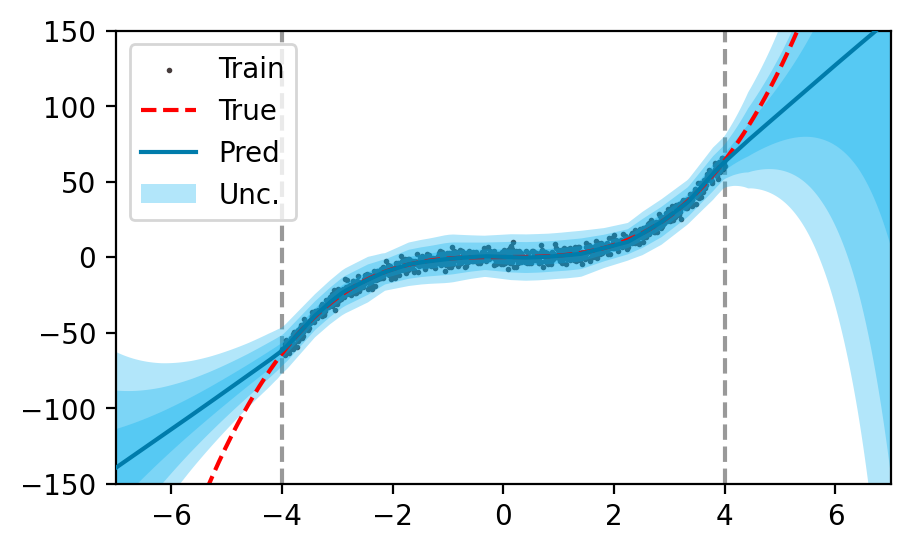

In [3]:
x_train, y_train = my_data(-4, 4, 1000)
x_test, y_test = my_data(-7, 7, 1000, train=False)
# Define our model with an evidential output
model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation="relu"),
        tf.keras.layers.Dense(64, activation="relu"),
        edl.layers.DenseNormalGamma(1),
])

# Custom loss function to handle the custom regularizer coefficient
def EvidentialRegressionLoss(true, pred):
    return edl.losses.EvidentialRegression(true, pred, coeff=1e-2)

# Compile and fit the model!
model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-4),
    loss=EvidentialRegressionLoss)
# model.fit(x_train, y_train, batch_size=100, epochs=500)
model.fit(x_train, y_train, batch_size=50, epochs=500)

# Predict and plot using the trained model
y_pred = model(x_test)
plot_predictions(x_train, y_train, x_test, y_test, y_pred)